# Cats vs Dogs: ANN vs CNN

This notebook compares an ANN baseline, a simple CNN, and a Transfer Learning (MobileNetV2) model on the Cats vs Dogs dataset (via TFDS).

- Dataset: TFDS `cats_vs_dogs` (split 80/20)
- Goal: Compare ANN vs CNN vs Transfer Learning performance and document training, callbacks, and results.


In [1]:
# Week2: Cat-vs-Dog (TFDS) - ANN vs CNN vs Transfer Learning
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Reproducibility (best-effort)
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
split_train = 'train[:80%]'
split_val = 'train[80%:]'

(ds_train_raw, ds_val_raw), ds_info = tfds.load('cats_vs_dogs', split=[split_train, split_val],
                                               with_info=True, as_supervised=True)
print(ds_info)

# quick dataset sizes
n_train = ds_info.splits['train'].num_examples * 0.8
n_val = ds_info.splits['train'].num_examples * 0.2
print(f"Estimated train images: {int(n_train)}, val images: {int(n_val)}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.DRF0RG_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings 

In [3]:
# Parameters
IMG_SIZE = (150,150)
BATCH_SIZE = 32

def preprocess(image, label, img_size=IMG_SIZE):

    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
])


train_ds = ds_train_raw.map(lambda x,y: preprocess(x,y,IMG_SIZE), num_parallel_calls=AUTOTUNE)
val_ds   = ds_val_raw.map(lambda x,y: preprocess(x,y,IMG_SIZE), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(2048, seed=SEED).map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


for imgs, labs in train_ds.take(1):
    print("Batch images shape:", imgs.shape, "labels shape:", labs.shape)
    break


Batch images shape: (32, 150, 150, 3) labels shape: (32,)


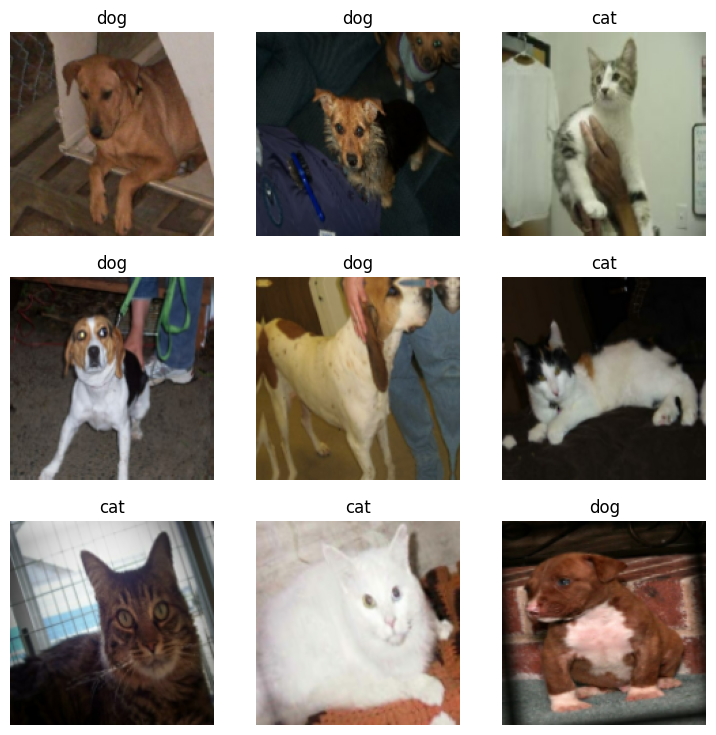

In [4]:
# Display a grid of images with labels
def show_samples(dataset, class_names=['cat','dog'], n=9):
    plt.figure(figsize=(9,9))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy())
            lbl = 'dog' if labels[i].numpy()==1 else 'cat'
            plt.title(lbl)
            plt.axis('off')
    plt.show()

show_samples(train_ds)


In [5]:
def plot_history(history, title_prefix=""):
    plt.figure(figsize=(12,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    # accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.show()


In [6]:
def build_ann_baseline(input_shape=(150,150,3)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Rescaling(1./255),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ], name="ANN_baseline")
    return model

ann_model = build_ann_baseline()
ann_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
ann_model.summary()


Model: "ANN_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,626,305 (132.09 MB)

 Trainable params: 34,626,305 (132.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5227 - loss: 0.6985

582/582 ━━━━━━━━━━━━━━━━━━━━ 126s 206ms/step - accuracy: 0.5227 - loss: 0.6985 - val_accuracy: 0.5441 - val_loss: 0.6857
Epoch 2/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5552 - loss: 0.6832

582/582 ━━━━━━━━━━━━━━━━━━━━ 117s 196ms/step - accuracy: 0.5552 - loss: 0.6832 - val_accuracy: 0.6103 - val_loss: 0.6774
Epoch 3/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 112s 188ms/step - accuracy: 0.5671 - loss: 0.6787 - val_accuracy: 0.5989 - val_loss: 0.6689
Epoch 4/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5738 - loss: 0.6733

582/582 ━━━━━━━━━━━━━━━━━━━━ 156s 264ms/step - accuracy: 0.5738 - loss: 0.6733 - val_accuracy: 0.6109 - val_loss: 0.6628
Epoch 5/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5878 - loss: 0.6692

582/582 ━━━━━━━━━━━━━━━━━━━━ 128s 216ms/step - accuracy: 0.5878 - loss: 0.6692 - val_accuracy: 0.6219 - val_loss: 0.6586
Epoch 6/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.5911 - loss: 0.6652 - val_accuracy: 0.6135 - val_loss: 0.6529
Epoch 7/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5994 - loss: 0.6629

582/582 ━━━━━━━━━━━━━━━━━━━━ 128s 216ms/step - accuracy: 0.5994 - loss: 0.6629 - val_accuracy: 0.6273 - val_loss: 0.6465
Epoch 8/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5955 - loss: 0.6587

582/582 ━━━━━━━━━━━━━━━━━━━━ 129s 217ms/step - accuracy: 0.5955 - loss: 0.6587 - val_accuracy: 0.6316 - val_loss: 0.6513
Epoch 9/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5955 - loss: 0.6592

582/582 ━━━━━━━━━━━━━━━━━━━━ 145s 244ms/step - accuracy: 0.5955 - loss: 0.6592 - val_accuracy: 0.6339 - val_loss: 0.6497
Epoch 10/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 111s 187ms/step - accuracy: 0.6080 - loss: 0.6544 - val_accuracy: 0.6279 - val_loss: 0.6412
Epoch 11/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 111s 186ms/step - accuracy: 0.6038 - loss: 0.6579 - val_accuracy: 0.6337 - val_loss: 0.6461
Epoch 12/12
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6023 - loss: 0.6551

582/582 ━━━━━━━━━━━━━━━━━━━━ 123s 208ms/step - accuracy: 0.6023 - loss: 0.6551 - val_accuracy: 0.6384 - val_loss: 0.6466


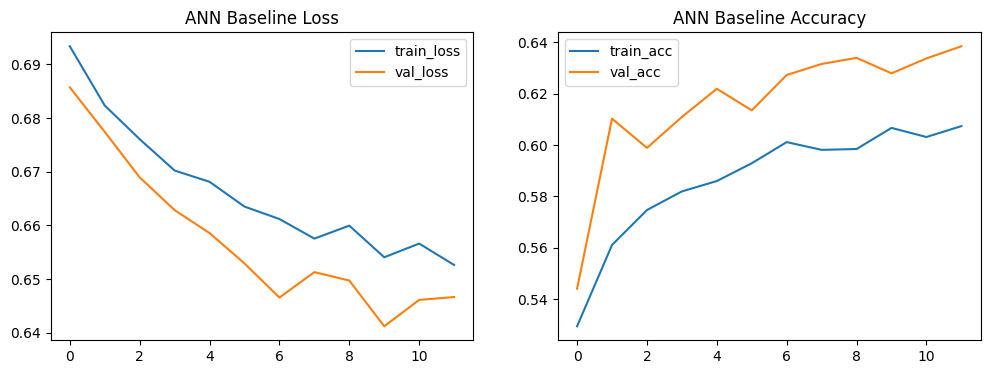

In [7]:

ann_ckpt_path = "/content/models/ann_catdog_best.h5"
os.makedirs("/content/models", exist_ok=True)

ann_es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ann_mc = callbacks.ModelCheckpoint(ann_ckpt_path, monitor='val_accuracy', save_best_only=True)


EPOCHS_ANN = 12
history_ann = ann_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_ANN,
    callbacks=[ann_es, ann_mc]
)
plot_history(history_ann, "ANN Baseline")


## ANN Model Summary (Cats vs Dogs)

- **Architecture**
  - Rescaling(1./255) → Flatten (150×150×3 → 67,500)
  - Dense(512, ReLU) → Dropout(0.5)
  - Dense(128, ReLU) → Dense(1, Sigmoid)

- **Training Setup**
  - Optimizer: Adam (lr=1e-3)
  - Loss: BinaryCrossentropy
  - Epochs: up to 12
  - Batch size: 32
  - Callbacks: EarlyStopping, ModelCheckpoint

- **Challenges**
  - Very large number of parameters from flattening; high risk of overfitting; poor generalization compared to CNN/TL.


146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6199 - loss: 0.6432
ANN validation loss, acc: [0.6411734819412231, 0.6279019713401794]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━

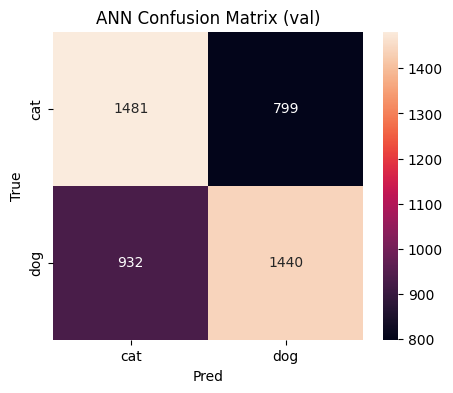

In [8]:
# Evaluate on validation set
ann_eval = ann_model.evaluate(val_ds, verbose=1)
print("ANN validation loss, acc:", ann_eval)

# Predictions for classification report and confusion matrix
y_true = []
y_pred = []
for imgs, labs in val_ds:
    preds = ann_model.predict(imgs)
    preds_bin = (preds.flatten() >= 0.5).astype(int)
    y_true.extend(labs.numpy().astype(int).tolist())
    y_pred.extend(preds_bin.tolist())

print("Classification report for ANN baseline:")
print(classification_report(y_true, y_pred, target_names=['cat','dog']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['cat','dog'], yticklabels=['cat','dog'])
plt.title("ANN Confusion Matrix (val)")
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()


In [9]:
def build_simple_cnn(input_shape=(150,150,3)):
    inputs = keras.Input(shape=input_shape)
    # Apply data augmentation layers directly
    x = layers.RandomFlip('horizontal')(inputs)
    x = layers.RandomRotation(0.08)(x)
    x = layers.RandomZoom(0.08)(x)

    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, outputs, name="Simple_CNN")

cnn_model = build_simple_cnn()
cnn_model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

Model: "Simple_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,710,593 (40.86 MB)

 Trainable params: 10,710,593 (40.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5038 - loss: 0.6932

582/582 ━━━━━━━━━━━━━━━━━━━━ 132s 212ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.4901 - val_loss: 0.6932
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 142s 220ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.4901 - val_loss: 0.6932
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.5074 - loss: 0.6931 - val_accuracy: 0.4901 - val_loss: 0.6932
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.5122 - loss: 0.6931 - val_accuracy: 0.4901 - val_loss: 0.6932
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.4901 - val_loss: 0.6933
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.5092 - loss: 0.6930 - val_accuracy: 0.4901 - val_loss: 0.6933
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.4901 - val_loss: 0.6933


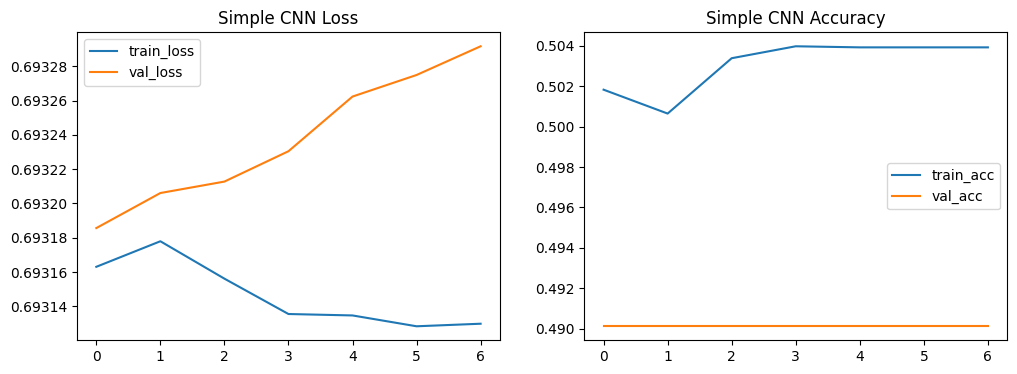

In [10]:
cnn_ckpt_path = "/content/models/cnn_catdog_best.h5"
cnn_es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
cnn_mc = callbacks.ModelCheckpoint(cnn_ckpt_path, monitor='val_accuracy', save_best_only=True)

EPOCHS_CNN = 15
history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_CNN,
    callbacks=[cnn_es, cnn_mc]
)
plot_history(history_cnn, "Simple CNN")


## Simple CNN Model Summary (Cats vs Dogs)

- **Architecture**
  - Rescaling + Data augmentation
  - Conv2D(32) → MaxPool
  - Conv2D(64) → MaxPool
  - Conv2D(128) → MaxPool
  - Flatten → Dense(256) → Dropout(0.5) → Dense(1, Sigmoid)

- **Training Setup**
  - Optimizer: Adam (lr=1e-4)
  - Loss: BinaryCrossentropy
  - Epochs: up to 25
  - Batch size: 32
  - Callbacks: EarlyStopping(patience=6), ModelCheckpoint('catdog_best.h5')

- **Challenges**
  - Dataset size and variability -> data augmentation & regularization needed; training longer on GPU required.


146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.4876 - loss: 0.6932
CNN validation loss, acc: [0.6931856274604797, 0.490111768245697]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


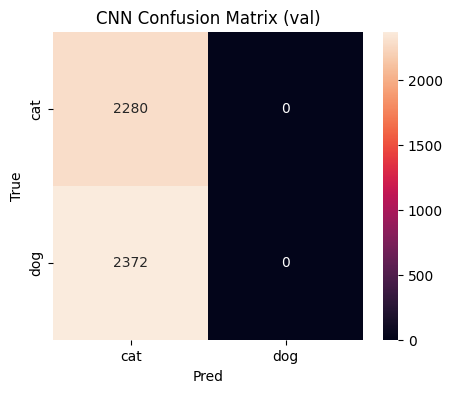

In [11]:
cnn_eval = cnn_model.evaluate(val_ds, verbose=1)
print("CNN validation loss, acc:", cnn_eval)

# Predictions
y_true = []
y_pred = []
for imgs, labs in val_ds:
    preds = cnn_model.predict(imgs)
    preds_bin = (preds.flatten() >= 0.5).astype(int)
    y_true.extend(labs.numpy().astype(int).tolist())
    y_pred.extend(preds_bin.tolist())

print("Classification report for CNN:")
print(classification_report(y_true, y_pred, target_names=['cat','dog']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['cat','dog'], yticklabels=['cat','dog'])
plt.title("CNN Confusion Matrix (val)")
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()


In [12]:
# Transfer Learning model (MobileNetV2 base)
IMG_SHAPE_TL = (224,224)   # MobileNetV2 default-ish
BATCH_SIZE_TL = 32

# Prepare datasets resized to 224x224 for TL
def preprocess_tl(image, label):
    image = tf.image.resize(image, IMG_SHAPE_TL)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_tl = ds_train_raw.map(preprocess_tl, num_parallel_calls=AUTOTUNE)
val_ds_tl = ds_val_raw.map(preprocess_tl, num_parallel_calls=AUTOTUNE)
train_ds_tl = train_ds_tl.shuffle(2048, seed=SEED).map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE_TL).prefetch(AUTOTUNE)
val_ds_tl = val_ds_tl.batch(BATCH_SIZE_TL).prefetch(AUTOTUNE)

base = keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base.trainable = False

inputs = keras.Input(shape=(224,224,3))
x = keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
tl_model = keras.Model(inputs, outputs, name="MobileNetV2_TL")

tl_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
tl_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobileNetV2_TL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5100 - loss: 0.7513

582/582 ━━━━━━━━━━━━━━━━━━━━ 260s 412ms/step - accuracy: 0.5100 - loss: 0.7513 - val_accuracy: 0.5099 - val_loss: 0.6918
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 207s 348ms/step - accuracy: 0.5007 - loss: 0.7330 - val_accuracy: 0.5099 - val_loss: 0.6902
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5142 - loss: 0.7165

582/582 ━━━━━━━━━━━━━━━━━━━━ 265s 356ms/step - accuracy: 0.5142 - loss: 0.7165 - val_accuracy: 0.5714 - val_loss: 0.6883
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 264s 360ms/step - accuracy: 0.5170 - loss: 0.7124 - val_accuracy: 0.5684 - val_loss: 0.6871
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 209s 354ms/step - accuracy: 0.5015 - loss: 0.7113 - val_accuracy: 0.5475 - val_loss: 0.6864


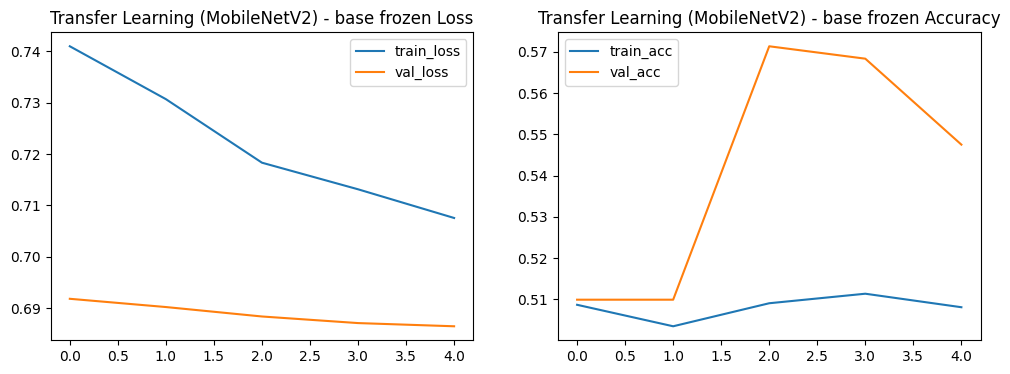

In [13]:
tl_ckpt_path = "/content/models/tl_catdog_best.h5"
tl_es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
tl_mc = callbacks.ModelCheckpoint(tl_ckpt_path, monitor='val_accuracy', save_best_only=True)

EPOCHS_TL = 5
history_tl = tl_model.fit(
    train_ds_tl,
    validation_data=val_ds_tl,
    epochs=EPOCHS_TL,
    callbacks=[tl_es, tl_mc]
)
plot_history(history_tl, "Transfer Learning (MobileNetV2) - base frozen")


## Transfer Learning (MobileNetV2) Summary

- **Architecture**
  - MobileNetV2 base (imagenet weights) as feature extractor (frozen initially)
  - GlobalAveragePooling → Dropout(0.4) → Dense(1, Sigmoid)

- **Training Setup**
  - Stage 1: freeze base, train top for ~8 epochs, Adam lr=1e-4
  - Stage 2 (optional fine-tune): unfreeze last N layers, train with small lr (1e-5) for few epochs
  - Callbacks: EarlyStopping, ModelCheckpoint

- **Notes**
  - Transfer learning gives the best tradeoff of speed and accuracy; recommended for real tasks with limited compute.


In [15]:
import os
from tensorflow import keras
from tensorflow.keras import layers

# Path to checkpoint saved by ModelCheckpoint
tl_ckpt_path = "/content/models/tl_catdog_best.h5"  # adjust if different

if os.path.exists(tl_ckpt_path):
    try:
        # Try to load full model (may fail due to 'TrueDivide' issue)
        best_tl = keras.models.load_model(tl_ckpt_path)
        print("Loaded full model successfully.")
    except Exception as e:
        print("Full model load failed with error:", e)
        print("=> Rebuilding the TL model architecture and loading weights instead (recommended).")

        # Rebuild the same TL model architecture you used for training
        # IMPORTANT: this must match the model you trained (MobileNetV2 base, top pooling, dropout, dense)
        base = keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
        base.trainable = False

        inputs = keras.Input(shape=(224,224,3))
        x = keras.applications.mobilenet_v2.preprocess_input(inputs)
        x = base(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.4)(x)
        outputs = layers.Dense(1, activation='sigmoid')(x)
        best_tl = keras.Model(inputs, outputs, name="MobileNetV2_TL_rebuilt")

        # compile (same loss/optimizer as used in training)
        best_tl.compile(optimizer=keras.optimizers.Adam(1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

        # Load weights from the saved .h5 file (this should work even if load_model fails)
        best_tl.load_weights(tl_ckpt_path)
        print("Weights loaded into rebuilt model successfully.")

    # Evaluate on your validation dataset (val_ds_tl must exist)
    try:
        best_eval = best_tl.evaluate(val_ds_tl, verbose=1)
        print("Best TL model eval (loss, acc):", best_eval)
    except NameError:
        print("val_ds_tl is not defined in this session — make sure you recreate/prepare the validation dataset (resized to 224x224) before evaluating.")
else:
    print("TL checkpoint not found at", tl_ckpt_path)


Full model load failed with error: Unknown layer: 'TrueDivide'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
=> Rebuilding the TL model architecture and loading weights instead (recommended).
Weights loaded into rebuilt model successfully.
146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.5758 - loss: 0.6879
Best TL model eval (loss, acc): [0.6883418560028076, 0.5713671445846558]


ANN model loaded.


CNN model loaded.
Full TL load failed (likely TrueDivide/custom op). Rebuilding TL architecture and loading weights.
TL weights loaded into rebuilt model.

Evaluating ANN Baseline...
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.6302 - loss: 0.6480
ANN Baseline eval (loss, acc): [0.646622896194458, 0.6384350657463074]

Classification report for ANN Baseline:
              precision    recall  f1-score   support

         cat       0.67      0.52      0.58      2280
         dog       0.62      0.76      0.68      2372

    accuracy                           0.64      4652
   macro avg       0.64      0.64      0.63      4652
weighted avg       0.64      0.64      0.63      4652



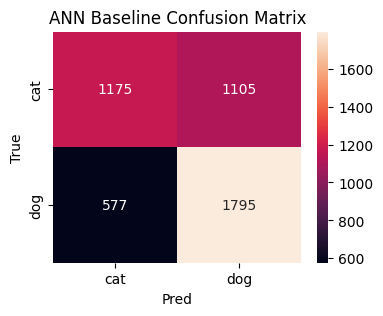


Evaluating Simple CNN...
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4876 - loss: 0.6932
Simple CNN eval (loss, acc): [0.6931856274604797, 0.490111768245697]

Classification report for Simple CNN:
              precision    recall  f1-score   support

         cat       0.49      1.00      0.66      2280
         dog       0.00      0.00      0.00      2372

    accuracy                           0.49      4652
   macro avg       0.25      0.50      0.33      4652
weighted avg       0.24      0.49      0.32      4652



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


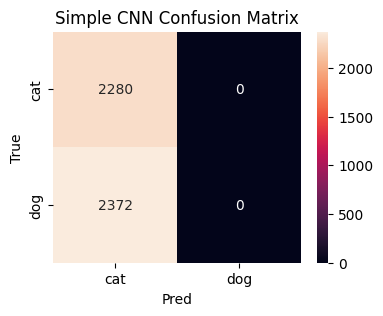


Evaluating Transfer Learning (MobileNetV2)...
146/146 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.5758 - loss: 0.6879
Transfer Learning (MobileNetV2) eval (loss, acc): [0.6883418560028076, 0.5713671445846558]

Classification report for Transfer Learning (MobileNetV2):
              precision    recall  f1-score   support

         cat       0.59      0.40      0.48      2280
         dog       0.56      0.73      0.64      2372

    accuracy                           0.57      4652
   macro avg       0.58      0.57      0.56      4652
weighted avg       0.58      0.57      0.56      4652



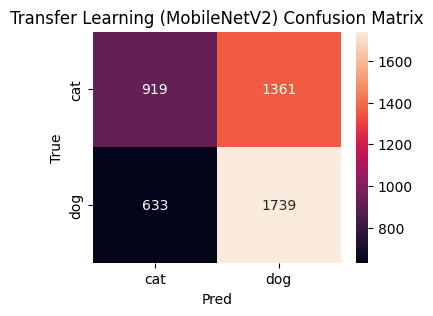


Summary of saved model files (in /content/models):
/content/models/ann_catdog_best.h5 -> FOUND
/content/models/cnn_catdog_best.h5 -> FOUND
/content/models/tl_catdog_best.h5 -> FOUND


In [16]:
# Combined final-eval + optional Drive-save cell
import os
import shutil
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to checkpoints (adjust if you saved elsewhere)
ann_ckpt_path = "/content/models/ann_catdog_best.h5"
cnn_ckpt_path = "/content/models/cnn_catdog_best.h5"
tl_ckpt_path  = "/content/models/tl_catdog_best.h5"

# Ensure val_ds and val_ds_tl exist in session; if val_ds_tl is missing, rebuild from ds_val_raw
try:
    val_ds  # noqa: F821
except NameError:
    print("val_ds not found in session. Make sure you have prepared `val_ds` (150x150) earlier.")
    val_ds = None

try:
    val_ds_tl  # noqa: F821
except NameError:
    print("val_ds_tl not found — rebuilding val_ds_tl from ds_val_raw resized to 224x224.")
    try:
        # ds_val_raw should exist from earlier TFDS load
        val_ds_tl = ds_val_raw.map(lambda x,y: (tf.image.resize(x, (224,224)), y), num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
    except Exception as e:
        print("Could not rebuild val_ds_tl automatically — ensure ds_val_raw exists or re-run TFDS loading cells.")
        val_ds_tl = None

# Helper to evaluate and print report + confusion matrix
def evaluate_and_report(model, dataset, dataset_is_tl=False, name="Model"):
    if model is None or dataset is None:
        print(f"Skipping {name}: model or dataset missing.")
        return
    print(f"\nEvaluating {name}...")
    eval_res = model.evaluate(dataset, verbose=1)
    print(f"{name} eval (loss, acc):", eval_res)
    # collect predictions and labels
    y_true, y_pred = [], []
    for imgs, labs in dataset:
        preds = model.predict(imgs, verbose=0)
        if preds.ndim > 1:
            preds = preds.flatten()
        preds_bin = (preds >= 0.5).astype(int)
        y_true.extend(labs.numpy().astype(int).tolist())
        y_pred.extend(preds_bin.tolist())
    print(f"\nClassification report for {name}:")
    print(classification_report(y_true, y_pred, target_names=['cat','dog']))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['cat','dog'], yticklabels=['cat','dog'])
    plt.title(f"{name} Confusion Matrix")
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.show()

# Try to load ANN model (full model HDF5)
ann_model = None
if os.path.exists(ann_ckpt_path):
    try:
        ann_model = keras.models.load_model(ann_ckpt_path)
        print("ANN model loaded.")
    except Exception as e:
        print("Failed to load ANN full model:", e)

# Try to load CNN model (full model HDF5)
cnn_model = None
if os.path.exists(cnn_ckpt_path):
    try:
        cnn_model = keras.models.load_model(cnn_ckpt_path)
        print("CNN model loaded.")
    except Exception as e:
        print("Failed to load CNN full model:", e)

# TL model: try load_model, fallback to rebuild & load_weights
tl_model = None
if os.path.exists(tl_ckpt_path):
    try:
        tl_model = keras.models.load_model(tl_ckpt_path)
        print("TL full model loaded.")
    except Exception as e:
        print("Full TL load failed (likely TrueDivide/custom op). Rebuilding TL architecture and loading weights.")
        # Rebuild MobileNetV2-based model (must match training definition)
        try:
            base = keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
            base.trainable = False
            inputs = keras.Input(shape=(224,224,3))
            x = keras.applications.mobilenet_v2.preprocess_input(inputs)
            x = base(x, training=False)
            x = layers.GlobalAveragePooling2D()(x)
            x = layers.Dropout(0.4)(x)
            outputs = layers.Dense(1, activation='sigmoid')(x)
            tl_model = keras.Model(inputs, outputs, name="MobileNetV2_TL_rebuilt")
            tl_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
            tl_model.load_weights(tl_ckpt_path)
            print("TL weights loaded into rebuilt model.")
        except Exception as ee:
            print("Failed to rebuild/load TL weights:", ee)
            tl_model = None
else:
    print("TL checkpoint not found at", tl_ckpt_path)

# Evaluate available models
if ann_model is not None and val_ds is not None:
    evaluate_and_report(ann_model, val_ds, name="ANN Baseline")

if cnn_model is not None and val_ds is not None:
    evaluate_and_report(cnn_model, val_ds, name="Simple CNN")

if tl_model is not None and val_ds_tl is not None:
    evaluate_and_report(tl_model, val_ds_tl, name="Transfer Learning (MobileNetV2)")

# Optional: copy models to Google Drive for persistence (uncomment to use)
# Make sure Drive is mounted (run: from google.colab import drive; drive.mount('/content/drive'))
# DRIVE_DIR = '/content/drive/MyDrive/models/catdog_week2'
# if os.path.exists('/content/drive'):
#     os.makedirs(DRIVE_DIR, exist_ok=True)
#     for p in [ann_ckpt_path, cnn_ckpt_path, tl_ckpt_path]:
#         if os.path.exists(p):
#             shutil.copy(p, DRIVE_DIR)
#     print("Copied available model files to Drive:", DRIVE_DIR)
# else:
#     print("Google Drive not mounted. To enable Drive save, mount Drive and set DRIVE_DIR.")

# Final summary printout
print("\nSummary of saved model files (in /content/models):")
for p in [ann_ckpt_path, cnn_ckpt_path, tl_ckpt_path]:
    print(p, "->", "FOUND" if os.path.exists(p) else "MISSING")


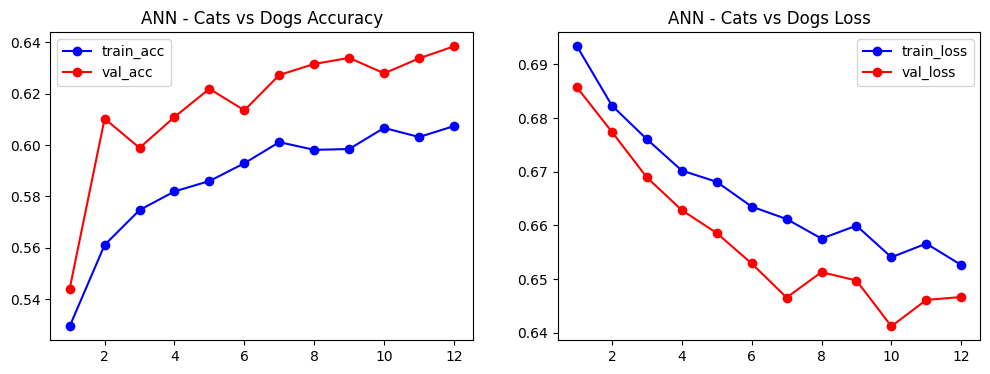

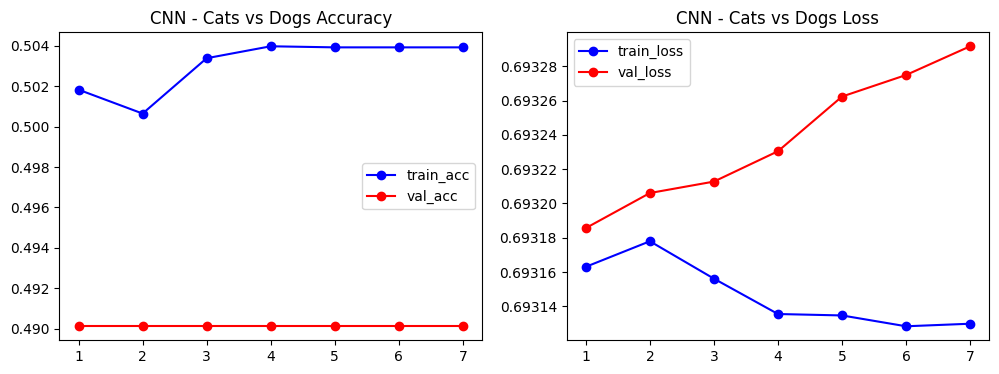

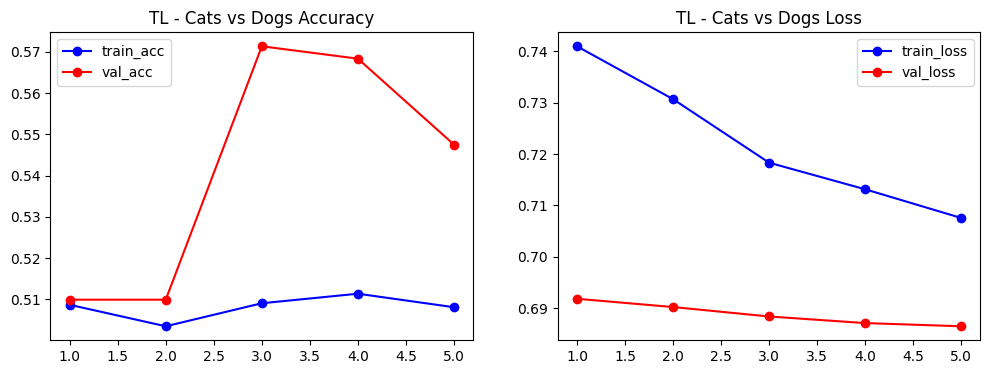

In [17]:
# Reuse the plot helper (same as MNIST)
def plot_history_safe(h, title="Training"):
    import matplotlib.pyplot as plt
    if h is None:
        print("No history for", title); return
    acc = h.history.get('accuracy') or h.history.get('acc')
    val_acc = h.history.get('val_accuracy') or h.history.get('val_acc')
    loss = h.history.get('loss')
    val_loss = h.history.get('val_loss')
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='train_acc')
    plt.plot(epochs, val_acc, 'ro-', label='val_acc')
    plt.title(f'{title} Accuracy'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='train_loss')
    plt.plot(epochs, val_loss, 'ro-', label='val_loss')
    plt.title(f'{title} Loss'); plt.legend()
    plt.show()

# Plot available histories
for name, hist_var in [('ANN', globals().get('history_ann')), ('CNN', globals().get('history_cnn')), ('TL', globals().get('history_tl')), ('TL_ft', globals().get('history_tl_ft'))]:
    if hist_var is not None:
        plot_history_safe(hist_var, title=name + " - Cats vs Dogs")


## ANN vs CNN vs Transfer Learning (Cats vs Dogs)

| Model | Train Accuracy | Val Accuracy | Notes |
|-------|----------------|--------------|-------|
| ANN (flattened) | (see plot) | (see report) | Poor generalization; too many params |
| Simple CNN | (see plot) | (see report) | Good baseline; benefits from augmentation |
| Transfer Learning (MobileNetV2) | (see plot) | (see report) | Best performance & recommended for production-like tasks |

**Reflection**  
- The CNN improves considerably over the ANN baseline; the TL model gives the best validation accuracy and generalization. Data augmentation and careful regularization are critical to avoid overfitting.


In [19]:

os.makedirs('figures', exist_ok=True)
plt.savefig('figures/catdog_cnn_accuracy.png')

from google.colab import drive
drive.mount('/content/drive')
DRIVE_DIR = '/content/drive/MyDrive/models/catdog_week2'
os.makedirs(DRIVE_DIR, exist_ok=True)
for f in ['/content/models/ann_catdog_best.h5','/content/models/cnn_catdog_best.h5','/content/models/tl_catdog_best.h5']:
    if os.path.exists(f): shutil.copy(f, DRIVE_DIR)


Mounted at /content/drive


<Figure size 640x480 with 0 Axes>